# Exporting data

Export the values of Ultimate tensile strength, Modulus, Baseline fiber volume, and Poisson's ratio for a set of records from the MI Training database.

This example demonstrates:

* Retrieving a list of databases from a Granta MI server
* Browsing the tables of a Granta MI database
* Searching a Granta MI database using the *CriteriaSearch* operation
* Retrieving values for attributes of a record

## Create a Granta MI Session

Import the GRANTA_MIScriptingToolkit package, and create a connection to a Granta MI server.

In [1]:
import GRANTA_MIScriptingToolkit as gdl

session = gdl.GRANTA_MISession('http://my.server.name/mi_servicelayer', autoLogon=True)

## Get the Databases

Access the browse service from the session and execute the *GetDatabases* method.

In [2]:
browseService = session.browseService
databases = browseService.GetDatabases().databases

print("Found {0} databases on the Granta MI Server".format(len(databases)))
for d in databases:
    print("Database key: {0.DBKey}, Database name: {0.volumeName}".format(d))

Found 1 databases on the Granta MI Server
Database key: MI_Training, Database name: MI Training


Use pandas to display the available databases.

In [3]:
import pandas as pd

df = pd.DataFrame({'DBKey': [db.DBKey for db in databases],
                  'DBName': [db.volumeName for db in databases]})
df

DBKey       DBName
0  MI_Training  MI Training

## Get the tables in a database

Use the *GetTables* method from the browse service to see what tables are available in the MI Training database.

In [4]:
dbKey = "MI_Training"

tables = browseService.GetTables(gdl.GetTables(DBKey=dbKey)).tableDetails

print("Found {0} tables in database {1}".format(len(tables), dbKey))
for t in tables:
    print("Table name: {0}".format(t.tableReference.name))

Found 20 tables in database MI_Training
Table name: MaterialUniverse
Table name: ProcessUniverse
Table name: Restricted Substances
Table name: Legislations and Lists
Table name: Design Data
Table name: Composite Design Data
Table name: Tensile Statistical Data
Table name: Tensile Test Data
Table name: Shear Test Data
Table name: Fatigue Statistical Data
Table name: Fatigue Test Data
Table name: Specification Values
Table name: Metals Pedigree
Table name: Composite Pedigree
Table name: AM Builds
Table name: Machine learning: Test data
Table name: Machine learning: Builds
Table name: Training Exercise (completed)
Table name: Training Exercise for Import
Table name: Files for Training


## Searching a database

Search MI Training for all records in the Tensile Test Data table which have a defined *Young's modulus (11-axis) (normalized)*

In [5]:
table = 'Tensile Test Data'
attribute = "Young's modulus (11-axis) (normalized)"

tableRef = gdl.PartialTableReference(tableName=table)
attrRef = gdl.AttributeReference(name=attribute, DBKey=dbKey, partialTableReference=tableRef)
searchCriterion = gdl.RecordSearchCriterion(searchAttribute=attrRef, existsSearchValue=gdl.ExistsSearchValue())
request = gdl.CriteriaSearch(DBKey=dbKey, searchCriteria=[searchCriterion])

searchResults = session.searchService.CriteriaSearch(request).searchResults

Print the *shortName* and *longName* of each of the records returned by the search.

In [6]:
df2 = pd.DataFrame({'ShortName': [r.shortName for r in searchResults],
                     'LongName': [r.longName  for r in searchResults]})
df2

ShortName                                           LongName
0   LBJ6214A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...
1   LBJ5313A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...
2   LBJ4212A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...
3   LBJ1313A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...
4   LBJ8311A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...
5   LBJ6213A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...
6   LBJ4211A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...
7   LBJ4213A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...
8   LBJ1311A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...
9   LBJ1312A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...
10  LBJ8312A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...
11  LBJ8313A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...
12  LBJ6212A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...
13  LBJ5311A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...
14  LBJ5312A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...

## Export data from records

Create attribute references for the attributes you want to export and export data from all records.

In [7]:
attributes = ["Young's Modulus (11-axis) (normalized)", "Ultimate tensile strength (normalized)",
              "Baseline fiber volume", "Elastic Poisson's Ratio (12-plane)"]

attrRefs = [gdl.AttributeReference(name=a, DBKey=dbKey, partialTableReference=tableRef) for a in attributes]
recordRefs = [r.recordReference for r in searchResults]
request = gdl.GetRecordAttributesByRefRequest(recordReferences=recordRefs, attributeReferences=attrRefs)
       
recordData = session.dataExportService.GetRecordAttributesByRef(request).recordData

Print the values of the attributes from the exported records. Note that some records may not have values for all attributes.

In [8]:
s = [None]*len(df2)
for attribute in attributes:
    for idx, record in enumerate(recordData):
        attrValue = next((x for x in record.attributeValues if x.attributeName == attribute), None)
        s[idx] = attrValue.pointDataType.points[0].value if attrValue else None
    df2[attribute] = s
    
df2

ShortName                                           LongName  \
0   LBJ6214A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...   
1   LBJ5313A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...   
2   LBJ4212A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...   
3   LBJ1313A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...   
4   LBJ8311A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...   
5   LBJ6213A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...   
6   LBJ4211A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...   
7   LBJ4213A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...   
8   LBJ1311A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...   
9   LBJ1312A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...   
10  LBJ8312A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...   
11  LBJ8313A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...   
12  LBJ6212A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...   
13  LBJ5311A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...   
14  LBJ5312A  S-Glass Unitape S2/SP381, 3M, 0° tension, Spec...   

    Young's Modulus (11-axis) (normalized)  \
0                                46.387931   
1                                47.249776   
2                                45.774298   
3                                44.236767   
4                                48.428779   
5                                47.911673   
6                                48.028883   
7                                48.042673   
8                                47.118775   
9                                47.828935   
10                               49.276835   
11                               47.966831   
12                               49.076887   
13                               48.725254   
14                               48.835570   

    Ultimate tensile strength (normalized)  Baseline fiber volume  \
0                              1322.511090                 53.473   
1                              1490.005443                 53.473   
2                              1580.774931                 53.473   
3                              1505.711702                 53.473   
4                              1556.643278                 53.473   
5                              1392.975515                 53.473   
6                              1535.152318                 53.473   
7                              1601.486784                 53.473   
8                              1566.964731                 53.473   
9                              1557.622334                 53.473   
10                             1559.477024                 53.473   
11                             1571.811746                 53.473   
12                             1379.806528                 53.473   
13                             1559.456339                 53.473   
14                             1483.241686                 53.473   

    Elastic Poisson's Ratio (12-plane)  
0                                0.264  
1                                0.253  
2                                0.306  
3                                0.264  
4                                0.272  
5                                0.266  
6                                0.242  
7                                0.259  
8                                0.272  
9                                0.252  
10                               0.258  
11                               0.251  
12                               0.270  
13                               0.254  
14                               0.272

Create a plot of the exported values

<Axes: xlabel='Ultimate tensile strength (normalized)', ylabel="Young's Modulus (11-axis) (normalized)">

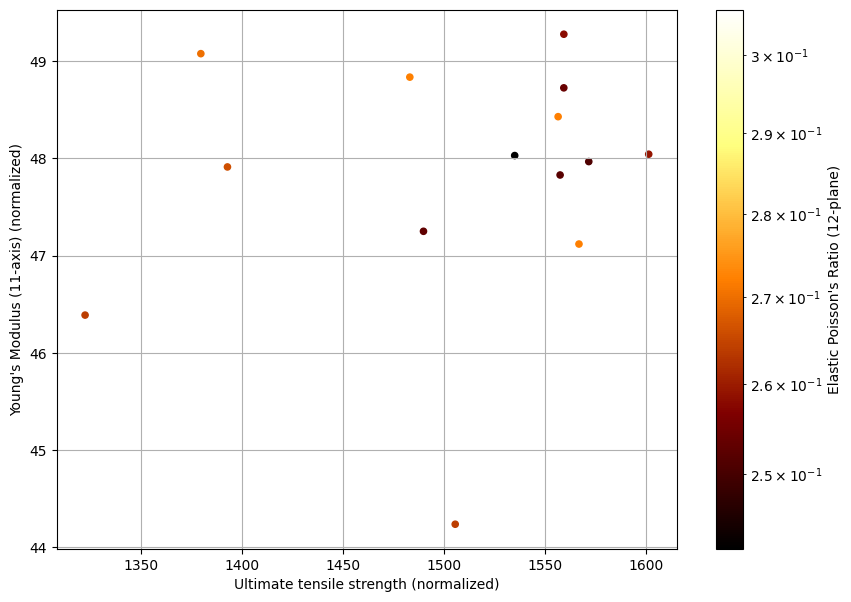

In [9]:
import matplotlib

df2.plot.scatter(x="Ultimate tensile strength (normalized)", y="Young's Modulus (11-axis) (normalized)", loglog=False,
                 c="Elastic Poisson's Ratio (12-plane)", colormap="afmhot", norm=matplotlib.colors.LogNorm(),
                 grid=True, figsize=(10, 7))